# KMeans for player clustering

In this notebook, we will train an unsupervised machine learning algorithm called KMeans.

KMeans is capable of discovering patterns in data and creating groups of similar data points.

In this notebook, we will use a dataset I scraped from FBREF on my own.

This dataset contains midfielders of the argentinian league. We want to cluster players that share similar characteristics. For example, more defensive, more offensive, playmaker, etc.

First we import the necessary packages.

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Let's start by reading the dataset using pandas.


In [85]:
players_df = pd.read_csv('FBRef_2024_CopaDeLaLiga_MidfieldersAnalysis.csv')

## Data preprocessing and cleanup

We check the column names, non-null count and types and examine what we have at our disposal:

In [86]:
players_df.head()

,Unnamed: 0,Rk,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,...,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks
0,0,1,Matías Abaldo,uy URU,"MF,FW",Gimnasia ELP,20-025,2004,7,5,...,2,4,0,4,1,3,0,2,6,4
1,1,2,Luciano Abecasis,ar ARG,"MF,DF",Independiente Rivadavia,33-329,1990,12,10,...,2,10,1,19,0,4,15,11,21,11
2,2,3,Ramón Ábila,ar ARG,FW,Barracas Central,34-197,1989,9,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,Jonás Acevedo,ar ARG,"MF,FW",Instituto,27-082,1997,9,6,...,3,6,1,13,4,5,4,7,16,7
4,4,5,Guillermo Acosta,ar ARG,MF,Tucumán,35-180,1988,10,10,...,12,3,1,17,0,5,12,9,29,4


To get We only want players whose main position is MF, we have some that are DF, or FW. This will reduce our data sample.

In [87]:
players_df = players_df[players_df["Pos"] == "MF"]
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 4 to 796
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    178 non-null    int64 
 1   Rk                            178 non-null    object
 2   Player                        178 non-null    object
 3   Nation                        174 non-null    object
 4   Pos                           178 non-null    object
 5   Squad                         178 non-null    object
 6   Age                           174 non-null    object
 7   Born                          174 non-null    object
 8   Matches Played                178 non-null    object
 9   Starts                        178 non-null    object
 10  Min                           178 non-null    object
 11  90s                           178 non-null    object
 12  Gls                           178 non-null    object
 13  Ast                      

Which are the metrics that are going to help our algorithm cluster the different type of midfielders?
We exclude metrics that are not significant and will hinder our algorithm.
We excluded de 90' metrics, we are going to convert them all later.
We also excluded accuracy metrics, for example, the number of correct passes will not help us deduce the different type of midfielders.

In [88]:
metrics = ['Player', "Min", 'Gls', 'Ast', 'xG', 'xAG',
       'Progressive Carries', 'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attenpted', 'Total Passing Distance', 'xA',
       'Passes Completed', 'Switches', 'Through Balls',
       'Clearances',
       'Interceptions', 'Passes Blocked', 'Shots Blocked', 'Tackles', 'Total Blocks']

players_df = players_df[metrics]
players_df.columns

Index(['Player', 'Min', 'Gls', 'Ast', 'xG', 'xAG', 'Progressive Carries',
       'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attenpted',
       'Total Passing Distance', 'xA', 'Passes Completed', 'Switches',
       'Through Balls', 'Clearances', 'Interceptions', 'Passes Blocked',
       'Shots Blocked', 'Tackles', 'Total Blocks'],
      dtype='object')

Convert all columns to numeric, excluding the "player column"

In [89]:
players_df.iloc[:, 1:] = players_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

Players that did not play sufficient amount of minutes will have data that may not be accurate to the player. We exclude players with less than 500 minutes played that season.

In [90]:
# Filter the DataFrame for rows where 'Min' > 500
players_df = players_df[players_df['Min'] > 500]
players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Player                        77 non-null     object
 1   Min                           77 non-null     object
 2   Gls                           77 non-null     object
 3   Ast                           77 non-null     object
 4   xG                            69 non-null     object
 5   xAG                           69 non-null     object
 6   Progressive Carries           69 non-null     object
 7   Progressive Passes            69 non-null     object
 8   Crosses into Penalty Area     69 non-null     object
 9   Key Passes                    69 non-null     object
 10  Long Passes Attempted         69 non-null     object
 11  Medium Passes Attempted       69 non-null     object
 12  Passes into Final Third       69 non-null     object
 13  Passes into Penalty Ar

We want to convert all the metrics to per 90' scale, first we copy the dataframe into another variable

In [91]:
players_90 = players_df.copy(deep=True)

Create a new column for the matches played, which is the player's total minutes divided by 90

In [92]:
players_90["Min_per_90"] = players_90["Min"] / 90

players_90[["Player", "Min", "Min_per_90"]].head()

,Player,Min,Min_per_90
0,Guillermo Acosta,782,8.688889
1,William Alarcón,1101,12.233333
2,Brahian Alemán,706,7.844444
3,Rodrigo Aliendro,848,9.422222
4,Agustín Almendra,698,7.755556


In [93]:
# Perform the division for columns starting from the third column
players_90.iloc[:, 2:] = players_90.iloc[:, 2:].div(players_90["Min_per_90"], axis=0)

players_90.head()

,Player,Min,Gls,Ast,xG,xAG,Progressive Carries,Progressive Passes,Crosses into Penalty Area,Key Passes,...,Passes Completed,Switches,Through Balls,Clearances,Interceptions,Passes Blocked,Shots Blocked,Tackles,Total Blocks,Min_per_90
0,Guillermo Acosta,782,0.11509,0.0,0.046036,0.069054,1.381074,6.329923,0.11509,1.035806,...,32.340153,0.920716,0.11509,1.726343,1.381074,0.345269,0.11509,1.956522,0.460358,1.0
1,William Alarcón,1101,0.163488,0.245232,0.040872,0.147139,1.389646,8.174387,0.163488,0.899183,...,38.910082,0.490463,0.326975,1.144414,0.735695,0.245232,0.0,1.226158,0.245232,1.0
2,Brahian Alemán,706,0.0,0.0,0.127479,0.101983,1.402266,6.11898,0.254958,1.529745,...,30.977337,1.01983,0.382436,1.402266,0.509915,0.892351,0.127479,2.03966,1.01983,1.0
3,Rodrigo Aliendro,848,0.0,0.212264,0.106132,0.084906,0.849057,6.049528,0.0,1.804245,...,41.92217,0.106132,0.318396,0.636792,0.955189,2.016509,0.424528,2.441038,2.441038,1.0
4,Agustín Almendra,698,0.12894,0.12894,0.090258,0.141834,0.644699,4.512894,0.0,0.902579,...,34.555874,0.515759,0.25788,1.547278,1.418338,1.934097,0.25788,3.739255,2.191977,1.0


Now we drop the minutes columns

In [94]:
players_90.drop(columns=["Min_per_90", "Min"], inplace=True)

We want to reduce the scale of each feature by normalizing the data

In [95]:
minmax_scaler = MinMaxScaler()

# Exclude the player column
norm_X = players_90.iloc[:, 1:]

# We want to replace NaN values with 0
norm_X.fillna(0, inplace=True)

# Save the columns, so we create the dataframe again
cols = norm_X.columns

# Perform the normalization
norm_X = minmax_scaler.fit_transform(norm_X.to_numpy())

/tmp/ipykernel_1940/486177664.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  norm_X.fillna(0, inplace=True)
/tmp/ipykernel_1940/486177664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_X.fillna(0, inplace=True)


For KMeans algorithm, we want to reduce the numbers of components for an easier cluster using Principal Component Analysis (PCA)

In [96]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(norm_X)
reduced = pd.DataFrame(reduced)

reduced.head()


,0,1
0,0.101449,0.056052
1,0.329666,0.484576
2,0.390491,0.329395
3,0.607282,-0.164558
4,0.271680,-0.235058


What would be a good number of clusters?
There are different types of midfielders, for example we can have more offensive midfielders, playmakers, box to box, defensive midfielders, etc.

The elbow method will help find us find the number of clusters that would be optmal for our data.
WCSS variable will contain the wcss for each cluster, which is the distance between points within each cluster, the lower the more compact clusters are.

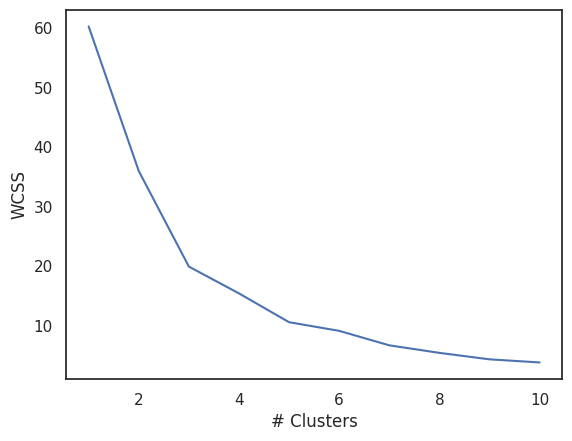

In [97]:
wcss = []

for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
        kmeans.fit(reduced)
        wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel("# Clusters")
plt.ylabel("WCSS")
plt.show()


Now that we found an optimal number of clusters, we train the model.

In [98]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

We need to combine player names with 

In [99]:
players = players_90["Player"]

reduced['cluster'] = clusters
reduced['name'] = players
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced

,x,y,cluster,name
0,0.101449,0.056052,3,Guillermo Acosta
1,0.329666,0.484576,2,William Alarcón
2,0.390491,0.329395,2,Brahian Alemán
3,0.607282,-0.164558,0,Rodrigo Aliendro
4,0.271680,-0.235058,0,Agustín Almendra
...,...,...,...,...
72,-1.613800,0.435204,1,Javier Urzúa
73,0.087756,-0.309789,3,Rodrigo Villagra
74,-0.273337,-0.564270,3,Carlos Villalba
75,0.835861,1.662903,2,Kevin Zenon


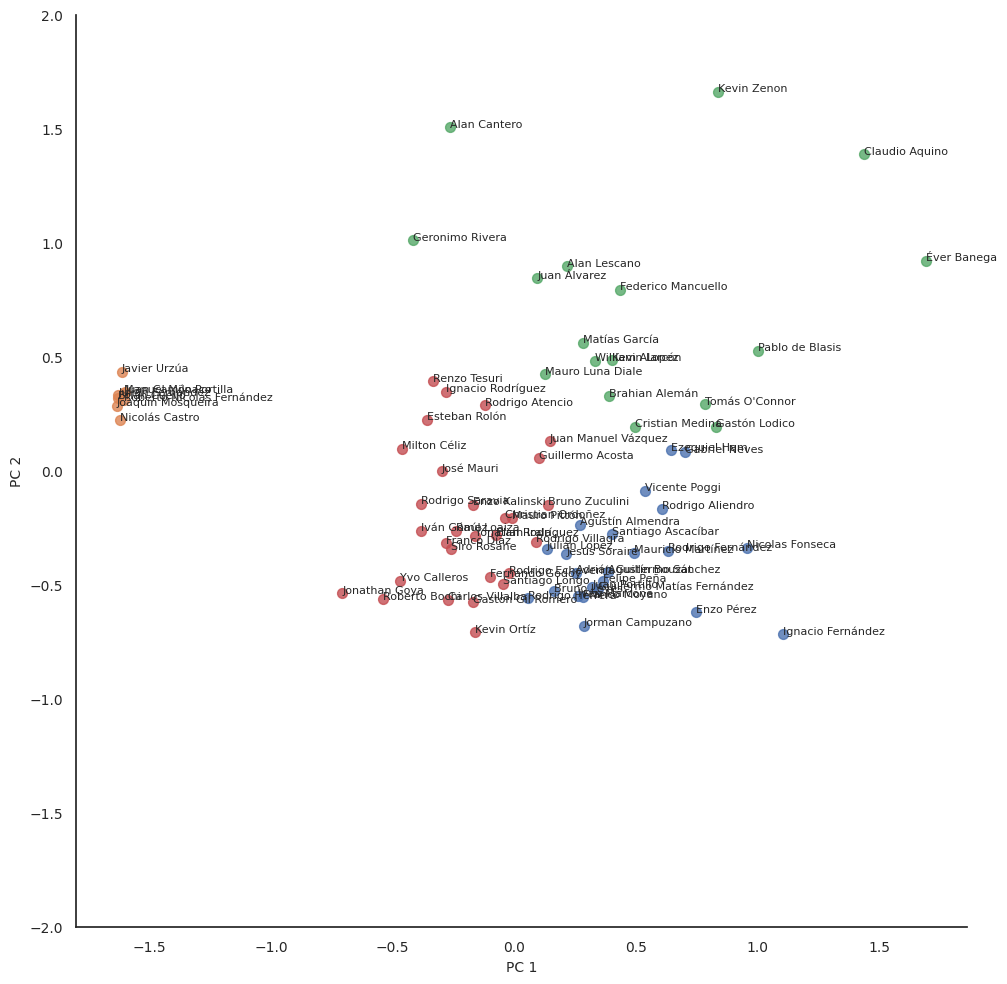

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Create the plot
ax = sns.lmplot(x="x", y="y", hue='cluster', data=reduced, legend=False,
                fit_reg=False, height=10, scatter_kws={"s": 50})

# Add text annotations with smaller font size
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s, fontsize=8))  # Adjust fontsize as needed

# Set the limits and labels
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=10)
plt.xlabel("PC 1", fontsize=10)
plt.ylabel("PC 2", fontsize=10)

plt.show()


,x,y,cluster,name
3,0.607282,-0.164558,0,Rodrigo Aliendro
4,0.271680,-0.235058,0,Agustín Almendra
7,0.400648,-0.276799,0,Santiago Ascacíbar
12,0.383305,-0.443238,0,Agustín Bouzat
15,0.284886,-0.677286,0,Jorman Campuzano
22,1.103591,-0.715271,0,Ignacio Fernández
24,0.631584,-0.348131,0,Rodrigo Fernández
25,0.957523,-0.335814,0,Nicolas Fonseca
31,0.254471,-0.445122,0,Adrián Guillermo Sánchez
32,0.644518,0.090497,0,Ezequiel Ham
